<a href="https://colab.research.google.com/github/dkapitan/jads-discover-projects/blob/main/ames-housing/homlr-chapter-4-linear-regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# install packages for Colab
# install.packages(c("rsample", "caret", "vip", "h2o", "AmesHousing", "viridis", "broom"))

# Helper packages
library(dplyr)      # for data manipulation
library(ggplot2)    # for awesome graphics
ggplot2::theme_set(ggplot2::theme_light())
library(viridis)
library(broom)

# Modeling process packages
library(rsample)    # for resampling
library(caret)      # for resampling and model training
library(h2o)       # for resampling and model training
h2o.no_progress()  # turn off h2o progress bars
h2o.init()         # launch h2o

# Model interpretability packages
library(vip)      # variable importance

# Ames housing data
library(AmesHousing)
ames <- AmesHousing::make_ames()
ames.h2o <- as.h2o(ames)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: viridisLite

Loading required package: lattice


----------------------------------------------------------------------

Your next step is to start H2O:
    > h2o.init()

For H2O package documentation, ask for help:
    > ??h2o

After starting H2O, you can use the Web UI at http://localhost:54321
For more information visit https://docs.h2o.ai

----------------------------------------------------------------------



Attaching package: ‘h2o’


The following objects are masked from ‘package:stats’:

    cor, sd, var


The following objects are masked from ‘package:base’:

    &&, %*%, %in%, ||, apply, as.factor, as.numeric, colnames,
    colnames<-, ifelse, is.character, is.factor, is.numeric, log,
    log10, log1p, log2, round, signif, trunc




 Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         20 minutes 42 seconds 
    H2O cluster timezone:       Europe/Amsterdam 
    H2O data parsing timezone:  UTC 
    H2O cluster version:        3.32.0.1 
    H2O cluster version age:    20 days  
    H2O cluster name:           H2O_started_from_R_dkapitan_fay557 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   3.54 GB 
    H2O cluster total cores:    8 
    H2O cluster allowed cores:  8 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:       NA 
    H2O Internal Security:      FALSE 
    H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, TargetEncoder, Core V4 
    R Version:                  R version 4.0.3 (2020-10-10) 




Attaching package: ‘vip’


The following object is masked from ‘package:utils’:

    vi




# Workflow using `rsample`

## Simple linear regression

### Estimation

In [2]:
# stratified sampling
set.seed(123)
split  <- initial_split(ames, prop = 0.7, strata = "Sale_Price")
ames_train  <- training(split)
ames_test   <- testing(split)

In [3]:
# linear model with single predictor
model1 <- lm(Sale_Price ~ Gr_Liv_Area, data = ames_train)

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



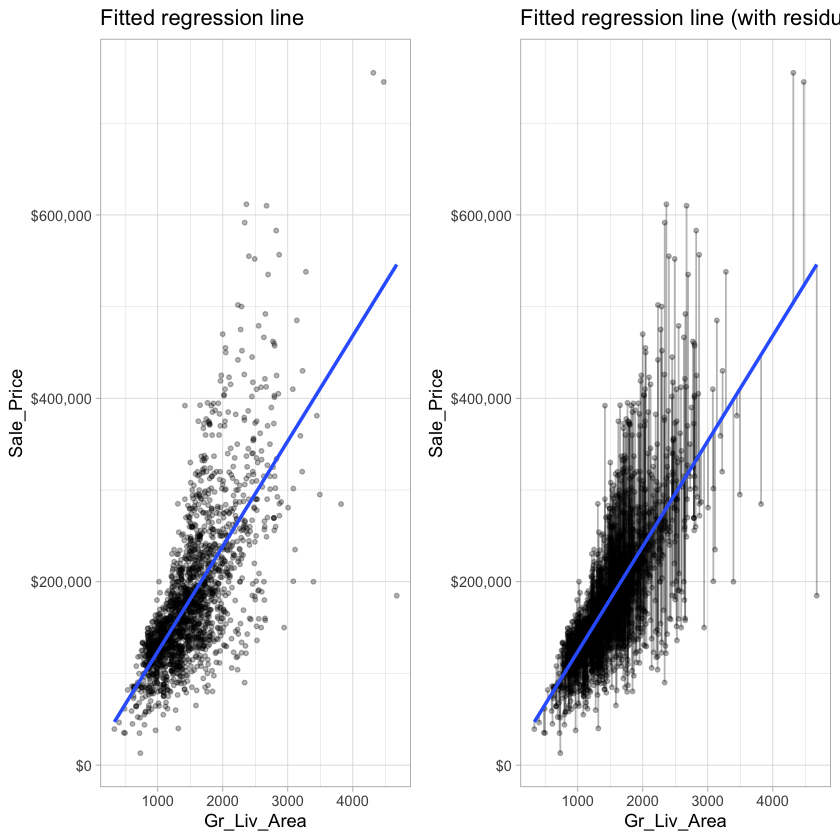

In [4]:
# Fitted regression line (full training data)
p1 <- model1 %>%
  broom::augment() %>%
  ggplot(aes(Gr_Liv_Area, Sale_Price)) + 
  geom_point(size = 1, alpha = 0.3) +
  geom_smooth(se = FALSE, method = "lm") +
  scale_y_continuous(labels = scales::dollar) +
  ggtitle("Fitted regression line")

# Fitted regression line (restricted range)
p2 <- model1 %>%
  broom::augment() %>%
  ggplot(aes(Gr_Liv_Area, Sale_Price)) + 
  geom_segment(aes(x = Gr_Liv_Area, y = Sale_Price,
                   xend = Gr_Liv_Area, yend = .fitted), 
               alpha = 0.3) +
  geom_point(size = 1, alpha = 0.3) +
  geom_smooth(se = FALSE, method = "lm") +
  scale_y_continuous(labels = scales::dollar) +
  ggtitle("Fitted regression line (with residuals)")

# Side-by-side plots
grid.arrange(p1, p2, nrow = 1)


In [5]:
summary(model1)


Call:
lm(formula = Sale_Price ~ Gr_Liv_Area, data = ames_train)

Residuals:
    Min      1Q  Median      3Q     Max 
-361143  -30668   -2449   22838  331357 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 8732.938   3996.613   2.185    0.029 *  
Gr_Liv_Area  114.876      2.531  45.385   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 56700 on 2051 degrees of freedom
Multiple R-squared:  0.5011,	Adjusted R-squared:  0.5008 
F-statistic:  2060 on 1 and 2051 DF,  p-value: < 2.2e-16


In [6]:
sigma(model1) #RMSE

[1] 56704.78

In [7]:
sigma(model1)^2 #MSE

[1] 3215432370

### Inference

In [8]:
confint(model1, level = 0.95)

,2.5 %,97.5 %
(Intercept),895.0961,16570.7805
Gr_Liv_Area,109.9121,119.8399


## Multiple linear regression

In [9]:
(model2 <- lm(Sale_Price ~ Gr_Liv_Area + Year_Built, data = ames_train))


Call:
lm(formula = Sale_Price ~ Gr_Liv_Area + Year_Built, data = ames_train)

Coefficients:
(Intercept)  Gr_Liv_Area   Year_Built  
 -2.123e+06    9.918e+01    1.093e+03  


In [10]:
(model2 <- update(model1, . ~ . + Year_Built))


Call:
lm(formula = Sale_Price ~ Gr_Liv_Area + Year_Built, data = ames_train)

Coefficients:
(Intercept)  Gr_Liv_Area   Year_Built  
 -2.123e+06    9.918e+01    1.093e+03  


In [11]:
lm(Sale_Price ~ Gr_Liv_Area + Year_Built + Gr_Liv_Area:Year_Built, data = ames_train)


Call:
lm(formula = Sale_Price ~ Gr_Liv_Area + Year_Built + Gr_Liv_Area:Year_Built, 
    data = ames_train)

Coefficients:
           (Intercept)             Gr_Liv_Area              Year_Built  
             3.822e+05              -1.484e+03              -1.798e+02  
Gr_Liv_Area:Year_Built  
             8.037e-01  


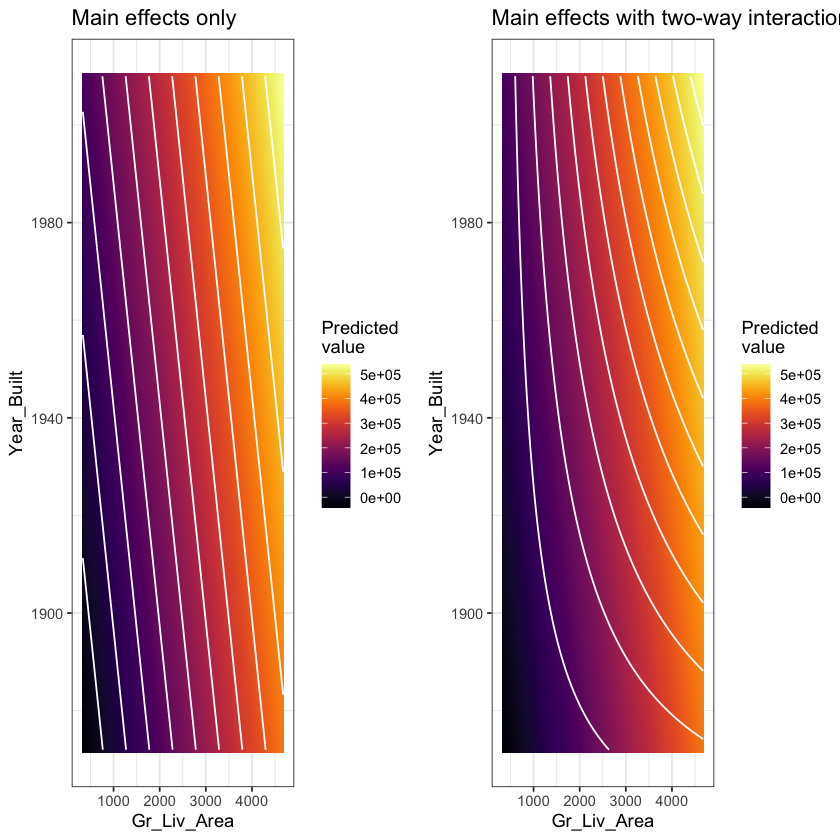

In [12]:
# Fitted models
fit1 <- lm(Sale_Price ~ Gr_Liv_Area + Year_Built, data = ames_train)
fit2 <- lm(Sale_Price ~ Gr_Liv_Area * Year_Built, data = ames_train)

# Regression plane data
plot_grid <- expand.grid(
  Gr_Liv_Area = seq(from = min(ames_train$Gr_Liv_Area), to = max(ames_train$Gr_Liv_Area), 
                    length = 100), 
  Year_Built = seq(from = min(ames_train$Year_Built), to = max(ames_train$Year_Built), 
                   length = 100)
)
plot_grid$y1 <- predict(fit1, newdata = plot_grid)
plot_grid$y2 <- predict(fit2, newdata = plot_grid)

# Level plots
p1 <- ggplot(plot_grid, aes(x = Gr_Liv_Area, y = Year_Built, 
                            z = y1, fill = y1)) +
  geom_tile() +
  geom_contour(color = "white") +
  viridis::scale_fill_viridis(name = "Predicted\nvalue", option = "inferno") +
  theme_bw() +
  ggtitle("Main effects only")
p2 <- ggplot(plot_grid, aes(x = Gr_Liv_Area, y = Year_Built, 
                            z = y2, fill = y1)) +
  geom_tile() +
  geom_contour(color = "white") +
  viridis::scale_fill_viridis(name = "Predicted\nvalue", option = "inferno") +
  theme_bw() +
  ggtitle("Main effects with two-way interaction")

gridExtra::grid.arrange(p1, p2, nrow = 1)

In [13]:
install.packages("broom")
library(broom)

Installing package into ‘/usr/local/lib/R/4.0/site-library’
(as ‘lib’ is unspecified)



In [14]:
# include all possible main effects
model3 <- lm(Sale_Price ~ ., data = ames_train) 

# print estimated coefficients in a tidy data frame
broom::tidy(model3)  

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-5.611498e+06,1.126188e+07,-0.49827360,6.183531e-01
MS_SubClassOne_Story_1945_and_Older,3.558042e+03,3.842733e+03,0.92591455,3.546166e-01
MS_SubClassOne_Story_with_Finished_Attic_All_Ages,1.279289e+04,1.283374e+04,0.99681743,3.189894e-01
MS_SubClassOne_and_Half_Story_Unfinished_All_Ages,8.730803e+03,1.287125e+04,0.67831840,4.976585e-01
MS_SubClassOne_and_Half_Story_Finished_All_Ages,4.109338e+03,6.225566e+03,0.66007455,5.092919e-01
MS_SubClassTwo_Story_1946_and_Newer,-1.093139e+03,5.790034e+03,-0.18879660,8.502739e-01
MS_SubClassTwo_Story_1945_and_Older,7.141541e+03,6.349431e+03,1.12475293,2.608462e-01
MS_SubClassTwo_and_Half_Story_All_Ages,-1.392803e+04,1.100256e+04,-1.26589014,2.057190e-01
MS_SubClassSplit_or_Multilevel,-1.145013e+04,1.051154e+04,-1.08929169,2.761736e-01


## Assessing model accuracy

In [15]:
# Train model using 10-fold cross-validation
set.seed(123)  # for reproducibility
(cv_model1 <- train(
  form = Sale_Price ~ Gr_Liv_Area, 
  data = ames_train, 
  method = "lm",
  trControl = trainControl(method = "cv", number = 10)
))

Linear Regression 

2053 samples
   1 predictor

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 1846, 1848, 1848, 1848, 1848, 1848, ... 
Resampling results:

  RMSE      Rsquared   MAE     
  56410.89  0.5069425  39169.09

Tuning parameter 'intercept' was held constant at a value of TRUE

In [16]:
# model 2 CV
set.seed(123)
cv_model2 <- train(
  Sale_Price ~ Gr_Liv_Area + Year_Built, 
  data = ames_train, 
  method = "lm",
  trControl = trainControl(method = "cv", number = 10)
)

# model 3 CV
set.seed(123)
cv_model3 <- train(
  Sale_Price ~ ., 
  data = ames_train, 
  method = "lm",
  trControl = trainControl(method = "cv", number = 10)
)

# Extract out of sample performance measures
summary(resamples(list(
  model1 = cv_model1, 
  model2 = cv_model2, 
  model3 = cv_model3
)))

Warning message in predict.lm(modelFit, newdata):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(modelFit, newdata):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(modelFit, newdata):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(modelFit, newdata):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(modelFit, newdata):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(modelFit, newdata):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(modelFit, newdata):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(modelFit, newdata):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(modelFit, newdata):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(modelFi


Call:
summary.resamples(object = resamples(list(model1 = cv_model1, model2
 = cv_model2, model3 = cv_model3)))

Models: model1, model2, model3 
Number of resamples: 10 

MAE 
           Min.  1st Qu.   Median     Mean  3rd Qu.     Max. NA's
model1 34457.58 36323.74 38943.81 39169.09 41660.81 45005.17    0
model2 28094.79 30594.47 31959.30 32246.86 34210.70 37441.82    0
model3 12458.27 15420.10 16484.77 16258.84 17262.39 19029.29    0

RMSE 
           Min.  1st Qu.   Median     Mean  3rd Qu.     Max. NA's
model1 47211.34 52363.41 54948.96 56410.89 60672.31 67679.05    0
model2 37698.17 42607.11 45407.14 46292.38 49668.59 54692.06    0
model3 20844.33 22581.04 24947.45 26098.00 27695.65 39521.49    0

Rsquared 
            Min.   1st Qu.    Median      Mean   3rd Qu.      Max. NA's
model1 0.3598237 0.4550791 0.5289068 0.5069425 0.5619841 0.5965793    0
model2 0.5714665 0.6392504 0.6800818 0.6703298 0.7067458 0.7348562    0
model3 0.7869022 0.9018567 0.9104351 0.8949642 0.9166564 0.930

## Model concerns

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'

`geom_smooth()` using formula 'y ~ x'



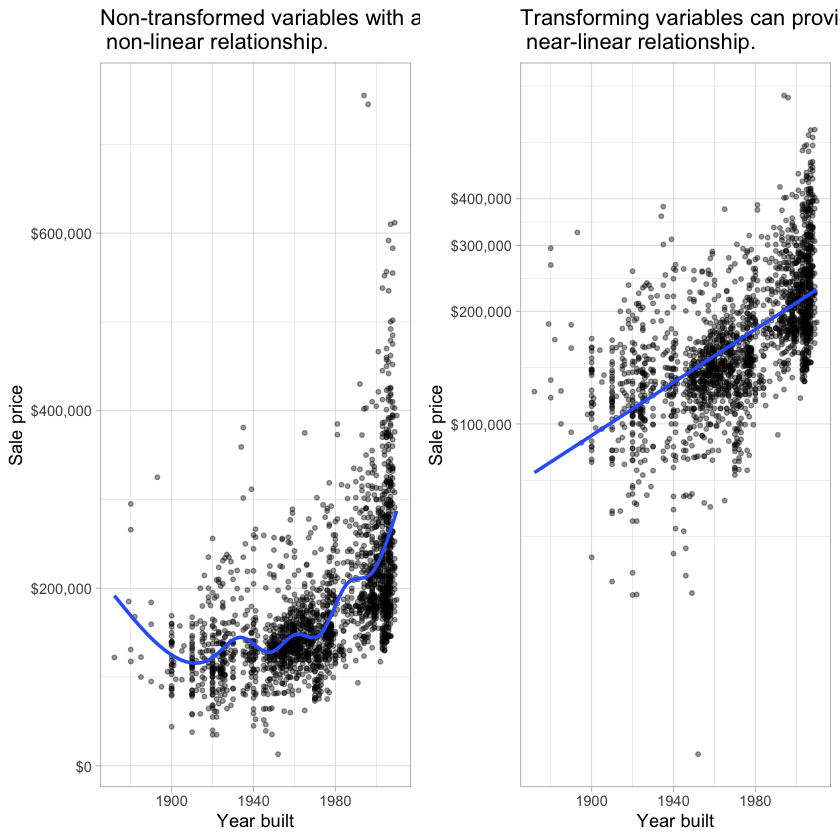

In [17]:
p1 <- ggplot(ames_train, aes(Year_Built, Sale_Price)) + 
  geom_point(size = 1, alpha = .4) +
  geom_smooth(se = FALSE) +
  scale_y_continuous("Sale price", labels = scales::dollar) +
  xlab("Year built") +
  ggtitle(paste("Non-transformed variables with a\n",
                "non-linear relationship."))

p2 <- ggplot(ames_train, aes(Year_Built, Sale_Price)) + 
  geom_point(size = 1, alpha = .4) + 
  geom_smooth(method = "lm", se = FALSE) +
  scale_y_log10("Sale price", labels = scales::dollar, 
                breaks = seq(0, 400000, by = 100000)) +
  xlab("Year built") +
  ggtitle(paste("Transforming variables can provide a\n",
                "near-linear relationship."))

gridExtra::grid.arrange(p1, p2, nrow = 1)

In [22]:
df1 <- broom::augment(cv_model1$finalModel, data = ames_train)

p1 <- ggplot(df1, aes(.fitted, .resid)) + 
  geom_point(size = 1, alpha = .4) +
  xlab("Predicted values") +
  ylab("Residuals") +
  ggtitle("Model 1", subtitle = "Sale_Price ~ Gr_Liv_Area")

df2 <- broom::augment(cv_model3$finalModel, data = ames_train)

p2 <- ggplot(df2, aes(.fitted, .resid)) + 
  geom_point(size = 1, alpha = .4)  +
  xlab("Predicted values") +
  ylab("Residuals") +
  ggtitle("Model 3", subtitle = "Sale_Price ~ .")

gridExtra::grid.arrange(p1, p2, nrow = 1)

ERROR: Error in FUN(X[[i]], ...): object '.resid' not found
